In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/ColabTemp"

In [2]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader
from torch import nn
from collections import OrderedDict
import matplotlib.pyplot as plt
import random
import copy
import os
import glob
import time
import numpy as np

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using '{device}' device")

Using 'cuda' device


In [4]:
mySeed = 42
torch.manual_seed(mySeed)
np.random.seed(mySeed)
random.seed(mySeed)
# tf.random.set_seed(mySeed)

In [5]:
# Hyper parameters
num_clients = 3
batch_size = 64
total_steps = 13
client_select_percentage = 1

dataset_name = "MNIST" # 'MNIST' or 'CIFAR10'
neural_network_type = "Conv" # 'MLP' or 'Conv'

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
client_epochs = 2

swap_step = 2
n_swap_bet_avg_p1 = 2 # p1=plus one to your number, if need 2 swap between avg, enter 3

remain = 0.001 # Remove some data for running faster in test

In [6]:
# Initialize parameters
client_selects = None
client_weights = None

passed_steps = 0

is_print_eval = False
start_bold = "\033[1m"
end_bold = "\033[0;0m"

neural_network_classname = f"Neural_Network_{dataset_name}_{neural_network_type}"
save_file_name_pre = f"FS_{dataset_name}_{neural_network_type}_{num_clients}c_{total_steps}s_{swap_step}_{n_swap_bet_avg_p1}_step"

## Load Data

In [7]:
# Download dataset
running_dataset = getattr(datasets, dataset_name)

train_data = running_dataset(
    root="../datasets",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10).scatter_(dim=0, index=torch.tensor(y), value=1)),
)

test_data = running_dataset(
    root="../datasets",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10).scatter_(dim=0, index=torch.tensor(y), value=1)),
)

print(len(train_data))
print(train_data[0][0].shape)
print(train_data[0][1])

60000
torch.Size([1, 28, 28])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [8]:
# Remove some data for running faster in test
print("full data size:", len(train_data))
train_data = torch.utils.data.Subset(train_data, range(0, int(len(train_data)*remain)))
print("cutted data size:", len(train_data))

full data size: 60000
cutted data size: 60


In [9]:
### Random dataset split for each client
client_data_size = np.array([len(train_data)//num_clients]*num_clients)
data_remain = len(train_data) % num_clients
for i in range(data_remain):
    client_data_size[-1-i] += 1

client_datasets = torch.utils.data.random_split(train_data, client_data_size)

### None random dataset split for each client
# client_datasets = list()
# i = 0
# for j in client_data_size:
#     client_datasets.append(torch.utils.data.Subset(train_data, range(i, i+j)))
#     i += j

In [10]:
# Create dataloader for each client
client_dataloaders = np.zeros(num_clients, dtype=object)
for i, dataset in enumerate(client_datasets):
    client_dataloaders[i] = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

## Training

In [11]:
def calc_out_conv_max_layers(in_w, in_h, kernels, strides, paddings=None, dilations=None):
    # In MaxPool2d, strides must same with kernels
    if paddings == None:
        paddings = np.zeros(len(kernels))
    
    if dilations == None:
        dilations = np.ones(len(kernels))
    
    out_w = in_w
    out_h = in_h
    for ker, pad, dil, stri in zip(kernels, paddings, dilations, strides):
        out_w = np.floor((out_w + 2*pad - dil * (ker-1) - 1)/stri + 1)
        out_h = np.floor((out_h + 2*pad - dil * (ker-1) - 1)/stri + 1)

    return int(out_w), int(out_h)

In [12]:
# Define MLP models
input_flat_size = torch.flatten(train_data[0][0]).shape[0]
nClasses = train_data[0][1].shape[0]

class Neural_Network_MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(input_flat_size, 100)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(100, 99)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(99, nClasses)),
        ]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        probs = self.softmax(logits)
        return probs
    
    def get_weights(self):
        return list(self.parameters())
    
    def set_weights(self, parameters_list):
        for i, param in enumerate(self.parameters()):
            param.data = parameters_list[i].data


class Neural_Network_CIFAR10_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(input_flat_size, 256)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(256, 128)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(128, 64)),
            ('relu3', nn.ReLU()),
            ('fc4', nn.Linear(64, nClasses)),
        ]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        print(logits)
        probs = self.softmax(logits)
        return probs
    
    def get_weights(self):
        return list(self.parameters())
    
    def set_weights(self, parameters_list):
        for i, param in enumerate(self.parameters()):
            param.data = parameters_list[i].data

In [13]:
# Define Convolutional models
input_channels, input_width, input_height = train_data[0][0].shape
conv_kernel = 3
max_kernel = 2

kernels = [conv_kernel, max_kernel, conv_kernel]
strides = [1, max_kernel, 1]
out_w1, out_h1 = calc_out_conv_max_layers(input_width, input_height, kernels, strides)

class Neural_Network_MNIST_Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.features_stack = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(input_channels, 32, kernel_size=conv_kernel, stride=1, padding=0)),
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(kernel_size=max_kernel)),
            ('conv2', nn.Conv2d(32, 64, kernel_size=conv_kernel)),
            ('relu2', nn.ReLU(inplace=True)),
            ('flat', nn.Flatten()),
            ('fc1', nn.Linear(64*out_w1*out_h1, nClasses)),
        ]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.features_stack(x)
        probs = self.softmax(logits)
        return probs

    def get_weights(self):
        return list(self.parameters())
    
    def set_weights(self, parameters_list):
        for i, param in enumerate(self.parameters()):
            param.data = parameters_list[i].data


kernels = [conv_kernel, max_kernel, conv_kernel, max_kernel]
strides = [1, max_kernel, 1, max_kernel]
out_w2, out_h2 = calc_out_conv_max_layers(input_width, input_height, kernels, strides)

class Neural_Network_CIFAR10_Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.features_stack = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(input_channels, 32, kernel_size=conv_kernel, stride=1, padding=0)),
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(kernel_size=max_kernel)),
            ('conv2', nn.Conv2d(32, 64, kernel_size=conv_kernel)),
            ('relu2', nn.ReLU(inplace=True)),
            ('pool2', nn.MaxPool2d(kernel_size=max_kernel)),
            ('flat', nn.Flatten()),
            ('fc1', nn.Linear(64*out_w2*out_h2, 100)),
            ('relu3', nn.ReLU(inplace=True)),
            ('fc2', nn.Linear(100, nClasses)),
        ]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.features_stack(x)
        probs = self.softmax(logits)
        return probs

    def get_weights(self):
        return list(self.parameters())
    
    def set_weights(self, parameters_list):
        for i, param in enumerate(self.parameters()):
            param.data = parameters_list[i].data

In [14]:
def select_clients_and_assign_weights(global_weights):
    global client_selects
    global client_weights

    lst = np.arange(0, num_clients)
    np.random.shuffle(lst)
    client_selects = lst[: int(len(lst)*client_select_percentage)]

    client_weights = {i: copy.deepcopy(global_weights)  for i in client_selects}

In [ ]:
# Create an instantiate of a class with string value!
global_model = globals()[neural_network_classname]().to(device)
global_weights = global_model.get_weights()
select_clients_and_assign_weights(global_weights)
print(global_model)

global_history = {"times": {"train":list(), "swap":list(), "step":list()},
                  "accuracy": list(),
                  "loss": list()}

# Load saved state & log
last_saved = sorted(glob.glob(f"{save_file_name_pre}_*.npz"), key=os.path.getmtime)
if last_saved:
    last_saved = last_saved[-1]
    passed_steps = int(last_saved.split("_")[-1].split(".")[0]) + 1

    npzFile = np.load(last_saved, allow_pickle=True)
    client_weights = npzFile["client_weights"].item()
    global_history = npzFile["global_history"].item()
    random_state = tuple(npzFile["random_state_ndarray"])
    np_random_state = tuple(npzFile["np_random_state_ndarray"])
    npzFile.close()

    random.setstate(random_state)
    np.random.set_state(np_random_state)

In [16]:
def scale_model_weights(weights, scalar):
    """ Scale the model weights """

    scaled_weights = list()
    for i in range(len(weights)):
        scaled_weights.append(weights[i] * scalar)

    return scaled_weights

In [17]:
def sum_scaled_weights(client_scaled_weights):
    """ Return the sum of the listed scaled weights.
        axis_O is equivalent to the average weight of the weights """

    avg_weights = list()
    # get the average gradient accross all client gradients
    for gradient_list_tuple in zip(*client_scaled_weights):
        gradient_list_tuple = [tensors.tolist()  for tensors in gradient_list_tuple]
        layer_mean = torch.sum(torch.tensor(gradient_list_tuple), axis=0).to(device)
        avg_weights.append(layer_mean)

    return avg_weights


### Explaining the function with example ###
# t = (torch.tensor([[[2, 3],[3, 4]], [[3, 4],[4, 5]], [[4, 5],[5, 6]]]),
#      torch.tensor([[[5, 6],[6, 7]], [[6, 7],[7, 8]], [[7, 8],[8, 9]]]))
# t = [i.tolist() for i in t]
# for y in zip(*t):
#     print(y)
#     print(torch.sum(torch.tensor(y), axis=0))

In [18]:
def fed_avg():
    # calculate total training data across clients
    global_count = 0
    for client in client_selects:
        global_count += len(client_dataloaders[client].dataset)

    # initial list to collect clients weight after scalling
    client_scaled_weights = list()
    for client in client_selects:
        local_count = len(client_dataloaders[client].dataset)
        scaling_factor = local_count / global_count
        scaled_weights = scale_model_weights(client_weights[client], scaling_factor)
        client_scaled_weights.append(scaled_weights)

    # to get the average over all the clients model, we simply take the sum of the scaled weights
    avg_weights = sum_scaled_weights(client_scaled_weights)

    return avg_weights

In [19]:
def fed_swap(client):
    random_num = random.randint(0, len(client_selects)-1)
    random_client = client_selects[random_num]

    temp_weights = client_weights[random_client]
    client_weights[random_client] = client_weights[client]

    return temp_weights

In [20]:
def test_neural_network(dataloader, model, loss_fn):
    data_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct_items = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct_items += (pred.argmax(1) == y.argmax(1)).sum().item()

    avg_loss = test_loss / num_batches
    accuracy = correct_items / data_size
    # print(f"Test Error: \nAccuracy: {(accuracy*100):>0.1f}%, Loss: {avg_loss:>8f}\n")

    return accuracy, avg_loss

In [21]:
def train_neural_network(dataloader, model, loss_fn, optimizer):
    data_size = len(dataloader.dataset)
    running_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        print_step = np.ceil(len(dataloader)/10)
        if batch % print_step == 0:
            loss_per_batch = running_loss / print_step
            current_item = (batch+1)*len(x)
            # print(f"loss: {loss_per_batch:>7f}  [{current_item:>5d}/{data_size:>5d}]")
            running_loss = 0

In [22]:
def train_clinet(dataloader, model):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    for epoch in range(client_epochs):
        train_neural_network(dataloader, model, loss_fn, optimizer)

In [23]:
def save_state_and_log(step):
    if step != 0:
        os.remove(f"{save_file_name_pre}_{step-1}.npz")
    
    random_state = random.getstate()
    np_random_state = np.random.get_state()
    random_state_ndarray = np.array(random_state, dtype=object)
    np_random_state_ndarray = np.array(np_random_state, dtype=object)

    np.savez_compressed(f"{save_file_name_pre}_{step}.npz", client_weights=client_weights, global_history=global_history,
             random_state_ndarray=random_state_ndarray, np_random_state_ndarray=np_random_state_ndarray)

In [24]:
def change_time_format(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    if h:
        return f"{h:.0f}h-{m:.0f}m-{s:.0f}s"
    elif m:
        return f"{m:.0f}m-{s:.0f}s"
    else:
        return f"{s:.2f}s"

In [25]:
def print_log(training_time, swapping_time, step_time, step, metric_index=-1):
    training_time = change_time_format(training_time)
    swapping_time = change_time_format(swapping_time)
    step_time = change_time_format(step_time)
    print(f"round: {step} | training_time: {training_time} | swapping_time: {swapping_time} | step_time: {step_time}")

    global is_print_eval
    if is_print_eval:
        is_print_eval = False
        print(f"round: {step} / global_acc: {start_bold}{global_history['accuracy'][metric_index]:.4%}{end_bold} / global_loss: {start_bold}{global_history['loss'][metric_index]:.4f}{end_bold}\n")

In [26]:
def print_prev_log(passed_steps):
    if passed_steps:
        global is_print_eval
        metric_index = -1

        for step in range(passed_steps):
            if (step % (swap_step*n_swap_bet_avg_p1) == 0):
                is_print_eval = True
                metric_index += 1

            training_time = global_history["times"]["train"][step]
            swapping_time = global_history["times"]["swap"][step]
            step_time = global_history["times"]["step"][step]
            print_log(training_time, swapping_time, step_time, step, metric_index)

In [27]:
# FedSwap Main Loop
print_prev_log(passed_steps)
for step in range(passed_steps, total_steps):
    training_time_start = time.time()
    for client in client_selects:
        local_model = globals()[neural_network_classname]().to(device)
        local_model.set_weights(client_weights[client])
        train_clinet(client_dataloaders[client], local_model)
        client_weights[client] = local_model.get_weights()

        del local_model
    
    training_time = time.time() - training_time_start
    global_history["times"]["train"].append(training_time)


    swapping_time_start = time.time()
    if (step % swap_step == 0) and (step % (swap_step*n_swap_bet_avg_p1) != 0):
        for client in client_selects:
            client_weights[client] = fed_swap(client)
    
    swapping_time = time.time() - swapping_time_start
    global_history["times"]["swap"].append(swapping_time)
    

    if (step % (swap_step*n_swap_bet_avg_p1) == 0):
        avg_weights = fed_avg()
        global_model.set_weights(avg_weights) # update global model
        select_clients_and_assign_weights(avg_weights)

        is_print_eval = True
        # test global model and print out metrics after each communication round
        global_acc, global_loss = test_neural_network(test_dataloader, global_model, loss_fn)
        global_history["accuracy"].append(global_acc)
        global_history["loss"].append(global_loss)
    
    step_time = time.time() - training_time_start
    global_history["times"]["step"].append(step_time)
    print_log(training_time, swapping_time, step_time, step)
    save_state_and_log(step)

round: 0 | training_time: 0.36s | swapping_time: 0.00s | step_time: 3.68s
round: 0 / global_acc: 18.0400% / global_loss: 2.2951

round: 1 | training_time: 0.06s | swapping_time: 0.00s | step_time: 0.06s
round: 2 | training_time: 0.07s | swapping_time: 0.00s | step_time: 0.07s
round: 3 | training_time: 0.06s | swapping_time: 0.00s | step_time: 0.06s
round: 4 | training_time: 0.08s | swapping_time: 0.00s | step_time: 3.45s
round: 4 / global_acc: 27.9700% / global_loss: 2.2249

round: 5 | training_time: 0.08s | swapping_time: 0.00s | step_time: 0.08s
round: 6 | training_time: 0.08s | swapping_time: 0.00s | step_time: 0.08s
round: 7 | training_time: 0.08s | swapping_time: 0.00s | step_time: 0.08s
round: 8 | training_time: 0.08s | swapping_time: 0.00s | step_time: 3.75s
round: 8 / global_acc: 49.2100% / global_loss: 2.0168

round: 9 | training_time: 0.07s | swapping_time: 0.00s | step_time: 0.07s
round: 10 | training_time: 0.09s | swapping_time: 0.00s | step_time: 0.09s
round: 11 | training

## Result

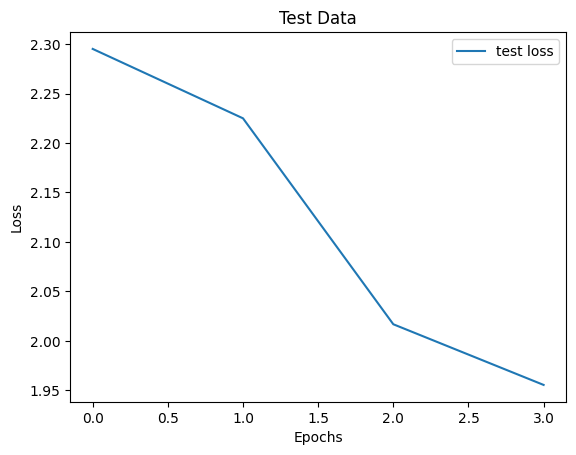

In [28]:
plt.plot(global_history["loss"], label="test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Data")
plt.legend()
plt.show()

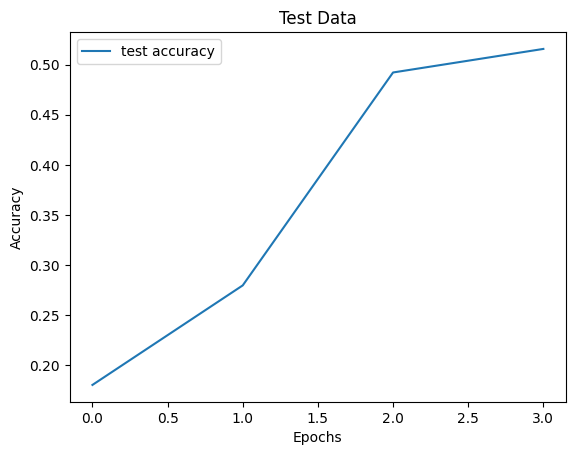

In [29]:
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()

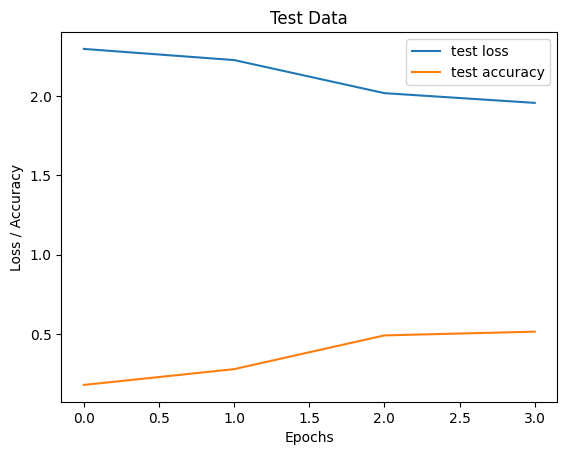

In [30]:
plt.plot(global_history["loss"], label="test loss")
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()